*Compiled on Jan 6, 2021 with scanpy v.1.6*

# Scanpy tutorial using 10k PBMCs dataset

This notebook should introduce you to some typical tasks, using Scanpy eco-system. Scanpy notebooks and tutorials are available [here](https://scanpy.readthedocs.io/en/stable/tutorials.html).
An alternative to this vignette in R (Seurat) is also available; interconversion and exploration of datasets from Python to Seurat (and SCE) is described in a separate vignette. 

The data consists in *10k PBMCs from a Healthy Donor* and is freely available from 10x Genomics from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets). We will use the data that had ambient RNA removed using SoupX, as described in yet another vignette. 

Let's import the necessary packages and read in the Cellranger-formatted data folder of SoupX output.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib as mpl
import numpy as np
import pandas as pd
import scanpy as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white', color_map='viridis')
sc.logging.print_header()

results_file = 'pbmc10k_scanpy.h5ad'

scanpy==1.7.1 anndata==0.7.5 umap==0.4.6 numpy==1.20.1 scipy==1.6.1 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


## PART 1. Basic quality control and filtering.

We start the analysis after two preliminary steps have been completed: 1) ambient RNA correction using `soupX`; 2) doublet detection using `scrublet`. Both vignettes can be found in this repository.

Reading the matrix with cache enabled helps save time on I/O operations, which is particularly relevant for bigger datasets. `SoupX` output only has gene symbols available, so no additional options are needed. If starting from typical Cellranger output, it's possible to choose if you want to use Ensemble ID (`gene_ids`) or gene symbols (`gene_symbols`) as expression matrix row names. 

In [2]:
adata = sc.read_10x_mtx('../data/soupX_pbmc10k_filt', cache = True)
adata

... writing an h5ad cache file to speedup reading next time


AnnData object with n_obs × n_vars = 10194 × 36601
    var: 'gene_ids', 'feature_types'

Let's make sure all gene names are unique. This is done with `var_names_make_unique` function. 

In [3]:
adata.var_names_make_unique()
adata
adata.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.5', 'AL627309.4', 'AP006222.2', 'AL732372.1',
       ...
       'AC133551.1', 'AC136612.1', 'AC136616.1', 'AC136616.3', 'AC136616.2',
       'AC141272.1', 'AC023491.2', 'AC007325.1', 'AC007325.4', 'AC007325.2'],
      dtype='object', length=36601)

We can also explore the newly created `AnnData` object. The `obs` field will contain all of per-cell metadata; for now, it only has the barcodes.

In [4]:
adata.obs.head()

Empty DataFrame
Columns: []
Index: [AAACCCACATAACTCG-1, AAACCCACATGTAACC-1, AAACCCAGTGAGTCAG-1, AAACCCAGTGCTTATG-1, AAACGAACAGTCAGTT-1]

We can view selected row or column names as follows:

In [5]:
print(adata.obs_names[10189:10194].tolist())
print()
print(adata.obs_names[-5:].tolist())
print()
print(adata.var_names[2000:2010].tolist())

['TTTGTTGGTCCGTACG-1', 'TTTGTTGGTCGGAACA-1', 'TTTGTTGGTTTACGAC-1', 'TTTGTTGTCGTTATCT-1', 'TTTGTTGTCTTTGCTA-1']

['TTTGTTGGTCCGTACG-1', 'TTTGTTGGTCGGAACA-1', 'TTTGTTGGTTTACGAC-1', 'TTTGTTGTCGTTATCT-1', 'TTTGTTGTCTTTGCTA-1']

['THEM5', 'THEM4', 'AL450992.2', 'AL450992.3', 'S100A10', 'AL450992.1', 'S100A11', 'TCHHL1', 'TCHH', 'AL589986.1']


Let's remove all genes expressed in fewer than 3 cells:

In [6]:
sc.pp.filter_genes(adata, min_cells=3)
adata

filtered out 14591 genes that are detected in less than 3 cells


AnnData object with n_obs × n_vars = 10194 × 22010
    var: 'gene_ids', 'feature_types', 'n_cells'

Let's show those genes that yield the highest fraction of counts in each single cell, across all cells.

normalizing counts per cell
    finished (0:00:00)


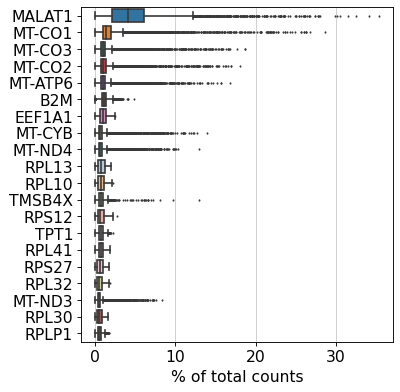

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20, )

Let's plot some information about mitochondrial genes, which is important for quality control (high MT gene content usually means dead cells). Note that you can also retrieve mitochondrial gene identifiers using `sc.queries.mitochondrial_genes_biomart('www.ensembl.org', 'mmusculus')`. We also will calculate the fraction of ribosomal proteins which can be used as another useful identifier of cell state. 

In [8]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
adata.var['rb'] = adata.var_names.str.startswith(('RPS','RPL'))  # annotate the group of ribosomal proteins as 'rb'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(adata, qc_vars=['rb'], percent_top=None, log1p=False, inplace=True)

A violin plot of the computed quality measures can help us analyze the dataset in general and make decisions about cutoffs.

... storing 'feature_types' as categorical


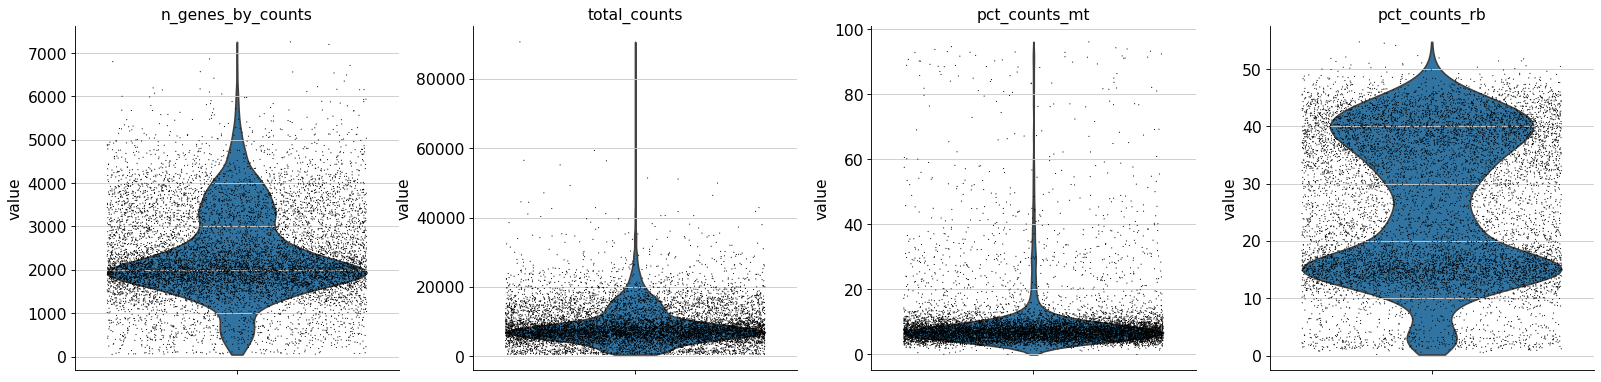

In [9]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_rb'], 
             jitter=0.4, multi_panel=True)

Take another look at per-cell metadata, which has many more columns now: 

In [10]:
adata.obs.head()

n_genes_by_counts  total_counts  total_counts_mt  \
AAACCCACATAACTCG-1               4734       22196.0           1171.0   
AAACCCACATGTAACC-1               2190        7629.0            674.0   
AAACCCAGTGAGTCAG-1               4246       21358.0           1342.0   
AAACCCAGTGCTTATG-1                342         857.0            269.0   
AAACGAACAGTCAGTT-1               4074       15006.0           1188.0   

                    pct_counts_mt  total_counts_rb  pct_counts_rb  
AAACCCACATAACTCG-1       5.275725           5564.0      25.067579  
AAACCCACATGTAACC-1       8.834710           2583.0      33.857651  
AAACCCAGTGAGTCAG-1       6.283360           4117.0      19.276150  
AAACCCAGTGCTTATG-1      31.388565             15.0       1.750292  
AAACGAACAGTCAGTT-1       7.916833           2249.0      14.987339

Finally, let's read in the table of doublet scores and doublet/singlet calls generated by `scrublet` in another vignette from this repository. 

In [11]:
doublets = pd.read_csv("../data/scrublet_calls.tsv", delimiter = '\t', 
                       header = None, index_col = 0,names = ['Doublet_score','Is_doublet'])
doublets.shape

(10194, 2)

Number of rows matches the number of cells we saw before (10194), which is good. Let's take a quick look at the table:

In [12]:
doublets.head()

Doublet_score  Is_doublet
AAACCCACATAACTCG-1       0.305424        True
AAACCCACATGTAACC-1       0.019761       False
AAACCCAGTGAGTCAG-1       0.031399       False
AAACCCAGTGCTTATG-1       0.027550       False
AAACGAACAGTCAGTT-1       0.368680        True

Let's add the table the `anndata.obs` so that we could plot the values against each other, use them for filtering, etc:

In [13]:
adata.obs = adata.obs.merge(doublets, left_index=True, right_index=True)
adata.obs.tail()

n_genes_by_counts  total_counts  total_counts_mt  \
TTTGTTGGTCCGTACG-1               3927       16565.0           1146.0   
TTTGTTGGTCGGAACA-1               1650        6364.0            331.0   
TTTGTTGGTTTACGAC-1               1387        4943.0            158.0   
TTTGTTGTCGTTATCT-1               2601        8080.0            534.0   
TTTGTTGTCTTTGCTA-1               3590       16095.0           1085.0   

                    pct_counts_mt  total_counts_rb  pct_counts_rb  \
TTTGTTGGTCCGTACG-1       6.918201           2569.0      15.508602   
TTTGTTGGTCGGAACA-1       5.201131           2928.0      46.008797   
TTTGTTGGTTTACGAC-1       3.196440           2189.0      44.284847   
TTTGTTGTCGTTATCT-1       6.608911           1285.0      15.903465   
TTTGTTGTCTTTGCTA-1       6.741224           2883.0      17.912395   

                    Doublet_score  Is_doublet  
TTTGTTGGTCCGTACG-1       0.029041       False  
TTTGTTGGTCGGAACA-1       0.019189       False  
TTTGTTGGTTTACGAC-1       0.109827       False  
TTTGTTGTCGTTATCT-1       0.040512       False  
TTTGTTGTCTTTGCTA-1       0.054908       False

Plot correlations and make sure that high mitochondrial content corresponds with low total counts (dead cells), and that total counts have strong positive correlation with the number of expressed genes:

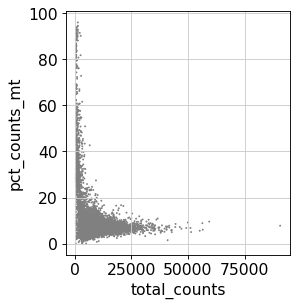

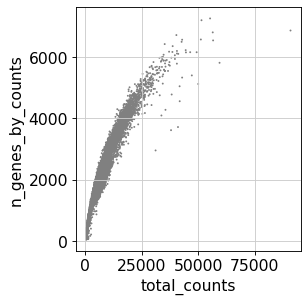

In [14]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

High ribosomal protein content, however, strongly anti-correlates with MT, and seems to contain biological signal.

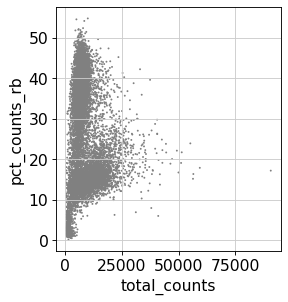

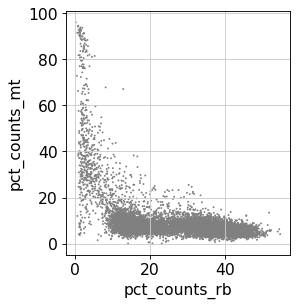

In [15]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_rb')
sc.pl.scatter(adata, x='pct_counts_rb', y='pct_counts_mt')

There's also a good correlation between the doublet score and number of expressed genes. 

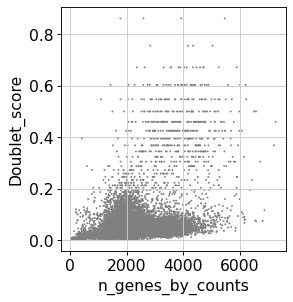

In [16]:
sc.pl.scatter(adata, x='n_genes_by_counts', y='Doublet_score')

Let's set QC column in metadata and define it in an informative way. Our metadata table looks as follows.

In [17]:
adata.obs.head()

n_genes_by_counts  total_counts  total_counts_mt  \
AAACCCACATAACTCG-1               4734       22196.0           1171.0   
AAACCCACATGTAACC-1               2190        7629.0            674.0   
AAACCCAGTGAGTCAG-1               4246       21358.0           1342.0   
AAACCCAGTGCTTATG-1                342         857.0            269.0   
AAACGAACAGTCAGTT-1               4074       15006.0           1188.0   

                    pct_counts_mt  total_counts_rb  pct_counts_rb  \
AAACCCACATAACTCG-1       5.275725           5564.0      25.067579   
AAACCCACATGTAACC-1       8.834710           2583.0      33.857651   
AAACCCAGTGAGTCAG-1       6.283360           4117.0      19.276150   
AAACCCAGTGCTTATG-1      31.388565             15.0       1.750292   
AAACGAACAGTCAGTT-1       7.916833           2249.0      14.987339   

                    Doublet_score  Is_doublet  
AAACCCACATAACTCG-1       0.305424        True  
AAACCCACATGTAACC-1       0.019761       False  
AAACCCAGTGAGTCAG-1       0.031399       False  
AAACCCAGTGCTTATG-1       0.027550       False  
AAACGAACAGTCAGTT-1       0.368680        True

The following command allows us to learn what is the data type of each column.

In [18]:
adata.obs.dtypes

n_genes_by_counts      int32
total_counts         float32
total_counts_mt      float32
pct_counts_mt        float32
total_counts_rb      float32
pct_counts_rb        float32
Doublet_score        float64
Is_doublet              bool
dtype: object

Let's add a new categorical column that would give us an approximate reason as to why a cell fails QC. Sometimes it would be more than one thing (e.g., low number of expressed genes often happens together with high MT gene content), but for simplicity we would let the order of comparison define the QC category.

After we set the values for QC, we can change the data type to 'category', and take a look at the result.

In [19]:
conditions = [
    (adata.obs['Is_doublet'] == True),
    (adata.obs['n_genes_by_counts'] < 500),
    (adata.obs['pct_counts_mt'] > 15),
    (adata.obs['pct_counts_mt'] <= 15) & (adata.obs['n_genes_by_counts'] >= 500) & (adata.obs['Is_doublet'] != True)
]

values = ['Doublet', 'Low_nFeature', 'High_MT', 'Pass']
adata.obs['QC'] = np.select(conditions, values)
adata.obs['QC'] = adata.obs['QC'].astype('category')
adata.obs[['Is_doublet','n_genes_by_counts','pct_counts_mt','QC']].head(10)

Is_doublet  n_genes_by_counts  pct_counts_mt            QC
AAACCCACATAACTCG-1        True               4734       5.275725       Doublet
AAACCCACATGTAACC-1       False               2190       8.834710          Pass
AAACCCAGTGAGTCAG-1       False               4246       6.283360          Pass
AAACCCAGTGCTTATG-1       False                342      31.388565  Low_nFeature
AAACGAACAGTCAGTT-1        True               4074       7.916833       Doublet
AAACGAACATTCGGGC-1       False               2284       7.763345          Pass
AAACGAAGTGATCATC-1        True               2167       6.348788       Doublet
AAACGAAGTTCGGGTC-1       False               2151      14.321314          Pass
AAACGAAGTTGAATCC-1       False               5133       8.643090          Pass
AAACGAATCCGTGGTG-1        True               3037       6.800667       Doublet

In [20]:
adata.obs['QC'].value_counts()

Pass            8824
High_MT          548
Doublet          547
Low_nFeature     275
Name: QC, dtype: int64

We can see that doublets don't often overlap with cell with low number of detected genes; at the same time, the latter often co-insides with high mitochondrial content. Let's plot metadata only for cells that pass tentative QC: 

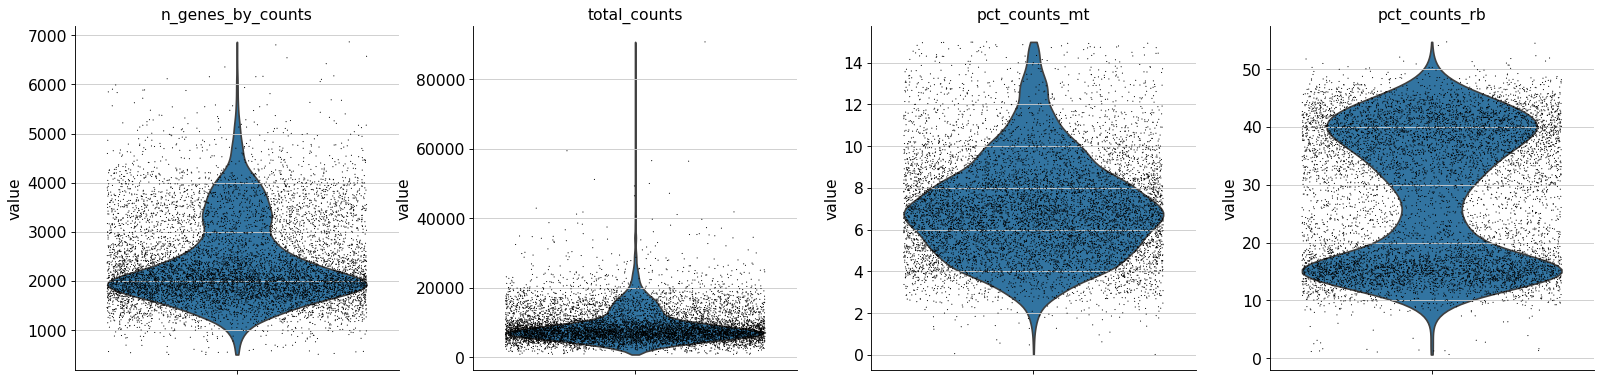

In [21]:
sc.pl.violin(adata[adata.obs['QC'] == 'Pass'], ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_rb'], 
             jitter=0.4, multi_panel=True)

## PART 2. Normalization and dimensionality reduction.

Total-count normalize (library-size correct) the data matrix 𝐗 to 10,000 reads per cell, so that counts become comparable among cells. The data are also log-transformed with a pseudocount of 1.

In [22]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata

normalizing counts per cell
    finished (0:00:00)


AnnData object with n_obs × n_vars = 10194 × 22010
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'Doublet_score', 'Is_doublet', 'QC'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'rb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'

Let's take a look at per-gene annotations added by the performed operations:

In [23]:
adata.var.head()

gene_ids    feature_types  n_cells     mt     rb  \
AL627309.1  AL627309.1  Gene Expression       40  False  False   
AL627309.5  AL627309.5  Gene Expression      522  False  False   
AL627309.4  AL627309.4  Gene Expression       12  False  False   
AL669831.2  AL669831.2  Gene Expression        7  False  False   
LINC01409    LINC01409  Gene Expression      671  False  False   

            n_cells_by_counts  mean_counts  pct_dropout_by_counts  \
AL627309.1                 40     0.003924              99.607612   
AL627309.5                522     0.056013              94.879341   
AL627309.4                 12     0.001177              99.882284   
AL669831.2                  7     0.000687              99.931332   
LINC01409                 671     0.071807              93.417697   

            total_counts  
AL627309.1          40.0  
AL627309.5         571.0  
AL627309.4          12.0  
AL669831.2           7.0  
LINC01409          732.0

Identify highly-variable genes to prioritize in further analysis.

In [24]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


Plot the highly variable genes, after and before the normalization.

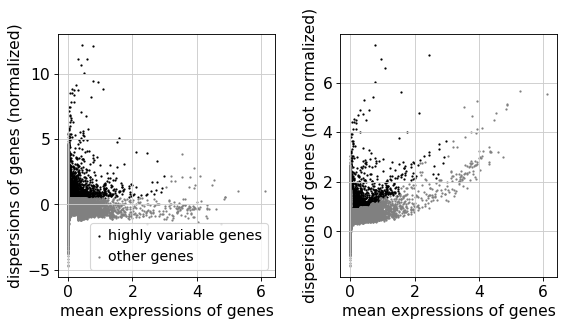

In [25]:
sc.pl.highly_variable_genes(adata)

See how many genes were determined to be highly variable:

In [26]:
adata.var.highly_variable.value_counts()

False    19140
True      2870
Name: highly_variable, dtype: int64

Save the raw data in a separate slot. For this, we set the `.raw` attribute of the `AnnData` object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the `AnnData` object. You can get back an `AnnData` of the object in `.raw` by calling `.raw.to_adata()`.

In [27]:
adata.raw = adata

Filter the genes, only keeping the most variable ones:

In [28]:
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 10194 × 2870
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'Doublet_score', 'Is_doublet', 'QC'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'rb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

Scale each gene to unit variance. Clip values exceeding standard deviation 10.

In [29]:
sc.pp.scale(adata, max_value=10)

/opt/conda/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [30]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:12)


Plot the first two components of PCA, coloring them by expression of CST3, which is a tentative marker of monocyte- and macrophage-like cells.

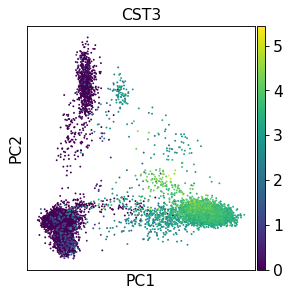

In [31]:
sc.pl.pca_scatter(adata, color='CST3')

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often, a rough estimate of the number of PCs does fine.

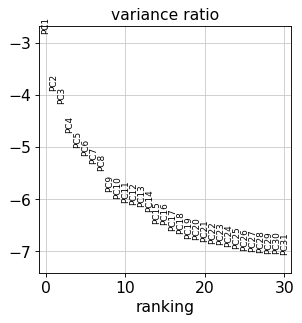

In [32]:
sc.pl.pca_variance_ratio(adata, log=True)

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of similarity with Seurat, let’s use the following values:

In [33]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:15)


UMAP and tSNE are popular methods used for dimensionality reduction and visualisation of very large datasets. UMAP is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preserves trajectories.

In [34]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


Let's plot some markers crudely defining large cell populations: monocytes (LYZ), B cells (MS4A1), and T cells (CD3D). Seems like general populations are nicely defined on our plot.

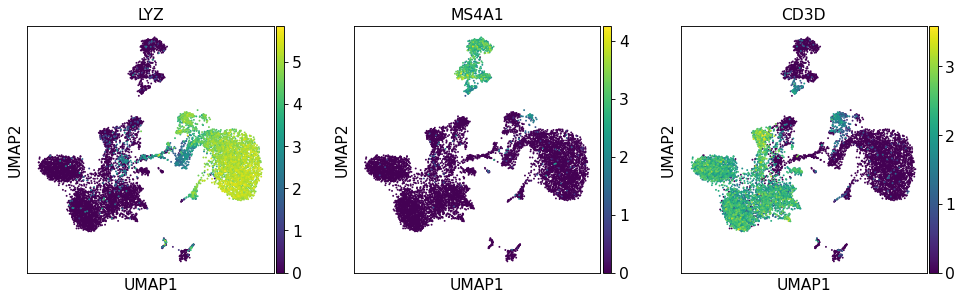

In [35]:
sc.pl.umap(adata, color=['LYZ','MS4A1','CD3D'])

As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by [Traag *et al.* (2018)](https://arxiv.org/abs/1810.08473). Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [36]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 20 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


Plot the data with UMAP, with coloring according to clustering. Some larger clusters are clearly identifiable as cell populations (see example marker plots above). Other smaller clusters can be attributed to doublets, cell cycle artefacts, etc.

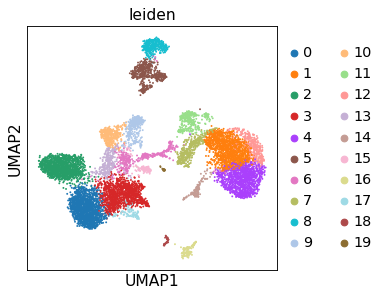

In [37]:
sc.pl.umap(adata, color=['leiden'])

Finally, let's calculate cell cycle scores, as described [here](https://nbviewer.jupyter.org/github/theislab/scanpy_usage/blob/master/180209_cell_cycle/cell_cycle.ipynb). Seurat has a built-in list; in `scanpy`, we would have to add the lists explicitly (see below), or read them in from the file. Note the use of `display` that allows you to print the outputs of multiple operations from one cell.

In [38]:
s_genes = ['MCM5','PCNA','TYMS','FEN1','MCM7','MCM4','RRM1','UNG','GINS2','MCM6','CDCA7','DTL','PRIM1',
           'UHRF1','CENPU','HELLS','RFC2','POLR1B','NASP','RAD51AP1','GMNN','WDR76','SLBP','CCNE2','UBR7',
           'POLD3','MSH2','ATAD2','RAD51','RRM2','CDC45','CDC6','EXO1','TIPIN','DSCC1','BLM','CASP8AP2',
           'USP1','CLSPN','POLA1','CHAF1B','MRPL36','E2F8']
g2m_genes = ['HMGB2','CDK1','NUSAP1','UBE2C','BIRC5','TPX2','TOP2A','NDC80','CKS2','NUF2','CKS1B',
             'MKI67','TMPO','CENPF','TACC3','PIMREG','SMC4','CCNB2','CKAP2L','CKAP2','AURKB','BUB1',
             'KIF11','ANP32E','TUBB4B','GTSE1','KIF20B','HJURP','CDCA3','JPT1','CDC20','TTK','CDC25C',
             'KIF2C','RANGAP1','NCAPD2','DLGAP5','CDCA2','CDCA8','ECT2','KIF23','HMMR','AURKA','PSRC1',
             'ANLN','LBR','CKAP5','CENPE','CTCF','NEK2','G2E3','GAS2L3','CBX5','CENPA']
cell_cycle_genes = s_genes + g2m_genes
display(len(s_genes))
display(len(g2m_genes))
display(len(cell_cycle_genes))

43

54

97

It is important to note that cell cycle analysis has to be done after normalization and scaling, and on the full set of genes, not just highly variable ones (remember that the full expression matrix is stored in `raw`). Thus, we would first recover the genes.

In [39]:
adata = adata.raw.to_adata()
adata

AnnData object with n_obs × n_vars = 10194 × 22010
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'Doublet_score', 'Is_doublet', 'QC', 'leiden'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'rb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'

Let's check how many of the defined cell cycle genes are present in our `var_names`:

In [40]:
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
len(cell_cycle_genes)

97

Looks like all the gene names were found successfully. Let's run the following command: 

In [41]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    727 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    815 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


Once this is done, we can do a more detailed exploration of our dataset, and filter the cells that do not pass the quality control. Let's visualize the values we use to define low quality cells:

... storing 'phase' as categorical


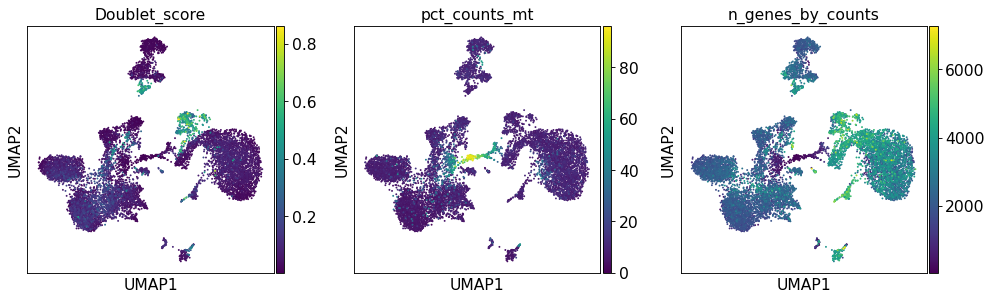

In [42]:
sc.pl.umap(adata, color=['Doublet_score','pct_counts_mt','n_genes_by_counts'])

We can see clear grouping of doublets, which is a sign that algorithm has worked correctly (see the vignette for more details). High MT content cells also form separate sub-clusters. Clusters clearly differ in the number of expressed genes, but this could be simply due to biological reasons. 

Let's remove the cells that did not pass QC and compare plots. We can now see much more defined clusters. Our filtered dataset now contains 8824 cells - so approximately 12% of cells were removed for various reasons. 

In [43]:
adata = adata[adata.obs['QC'] == 'Pass']
adata

View of AnnData object with n_obs × n_vars = 8824 × 22010
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'Doublet_score', 'Is_doublet', 'QC', 'leiden', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'rb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'

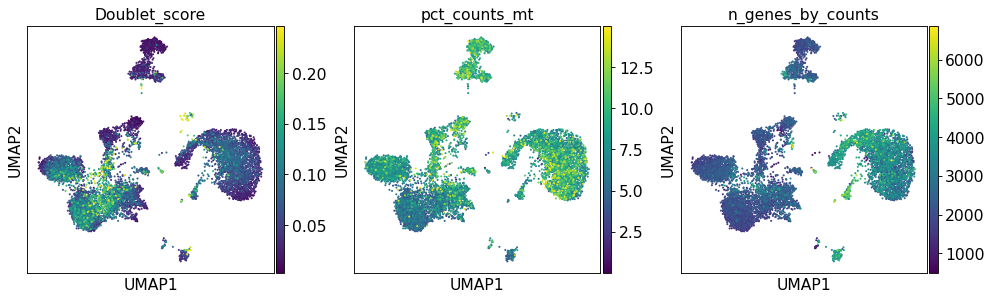

In [44]:
sc.pl.umap(adata, color=['Doublet_score','pct_counts_mt','n_genes_by_counts'])

Ribosomal protein genes show very strong dependency on the putative cell type! Some cell clusters seem to have as much as 45%, and some as little as 15%. It seems like monocytes have lower content of ribosomal proteins. Mitochnondrial genes also show certain dependency on cluster - e.g. the MT percentage is much lower in clusters 1 and 15.


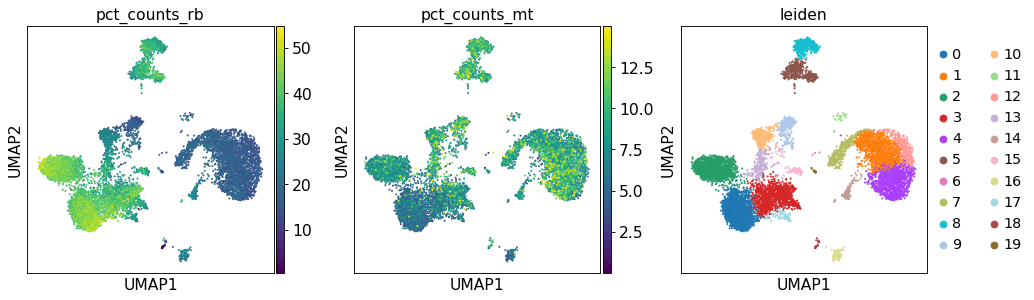

In [45]:
sc.pl.umap(adata, color=['pct_counts_rb','pct_counts_mt','leiden'])

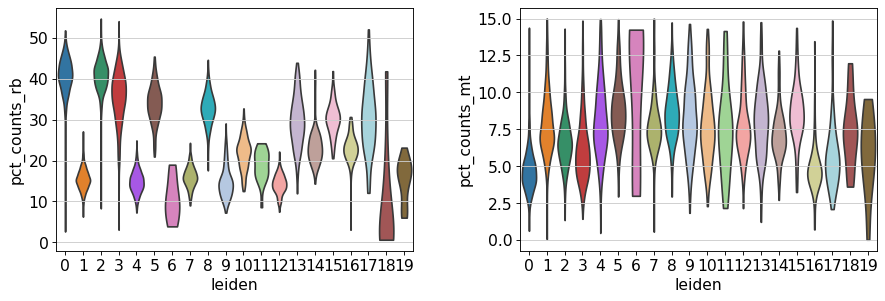

In [46]:
with mpl.rc_context({'figure.figsize': (5.5, 4)}):
    sc.pl.violin(adata, ['pct_counts_rb', 'pct_counts_mt'], groupby='leiden', stripplot = False )

Finally, cell cycle score does not seem to depend on the cell type much - however, there are dramatic outliers in each group. 

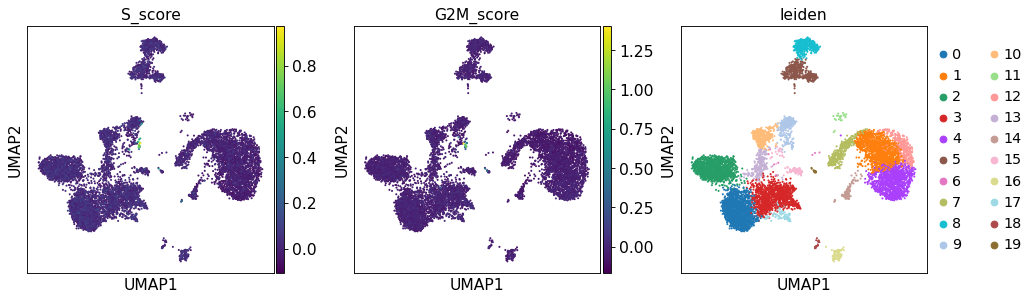

In [47]:
sc.pl.umap(adata, color=['S_score','G2M_score','leiden'])

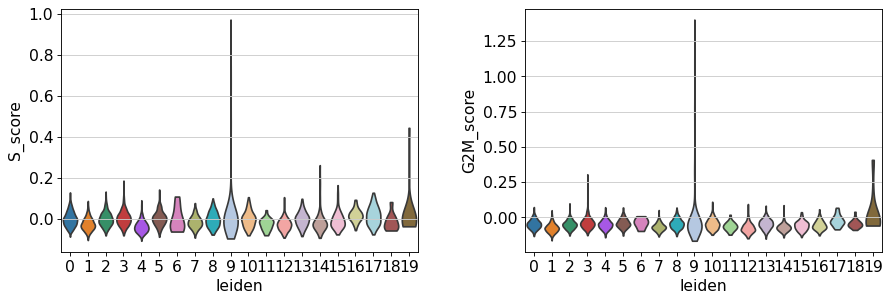

In [48]:
with mpl.rc_context({'figure.figsize': (5.5, 4)}):
    sc.pl.violin(adata, ['S_score','G2M_score'], groupby = 'leiden', stripplot = False)

There are also differences in RNA content per cell type. Some clusters will probably disapper when we redo the clustering using the QC-filtered dataset. 

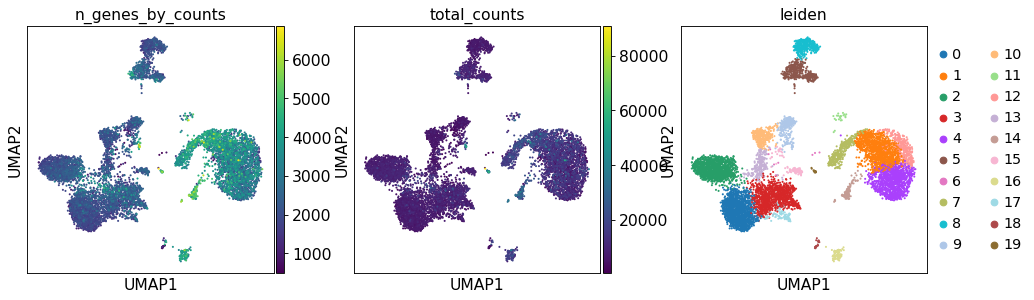

In [49]:
sc.pl.umap(adata, color=['n_genes_by_counts','total_counts','leiden'])

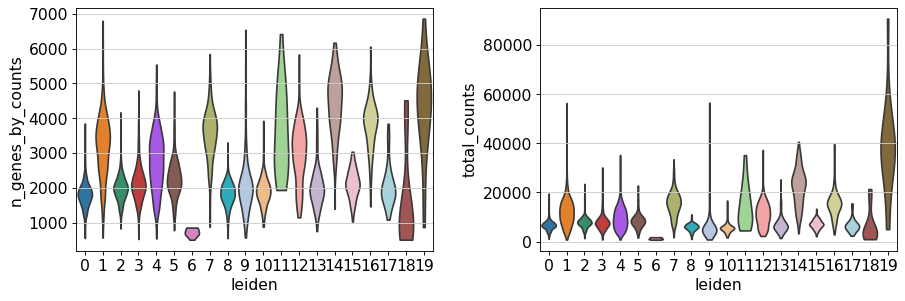

In [50]:
with mpl.rc_context({'figure.figsize': (5.5, 4)}):
    sc.pl.violin(adata, ['n_genes_by_counts','total_counts'], groupby = 'leiden', stripplot = False)

### PART 3. Normalization and careful clustering of the cleaned dataset.

Let's restart our analysis from the counts matrix again. First make sure we have all genes present in the active assay:

In [51]:
adata

View of AnnData object with n_obs × n_vars = 8824 × 22010
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'Doublet_score', 'Is_doublet', 'QC', 'leiden', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'rb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'

Let's redo HVG, PCA, UMAP, and clustering analysis, since now we have QC-filtered cells.

In [52]:
sc.pp.highly_variable_genes(adata, min_mean = 0.0125, max_mean = 3, min_disp = 0.5)
adata.var.highly_variable.value_counts()

extracting highly variable genes
    finished (0:00:00)
Trying to set attribute `.uns` of view, copying.
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


False    20005
True      2005
Name: highly_variable, dtype: int64

Much fewer (around 2000) genes are identified as HVG. Let's use these for subsequent analysis, keeping the full matrix in `raw`, as before:

In [53]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 8824 × 2005
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'Doublet_score', 'Is_doublet', 'QC', 'leiden', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'rb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'

Now, we shall regress out the confounding variables: total UMI count, MT percentage, and cell cycle scores. This step is somewhat slow (expect at least several minutes): 

In [54]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'S_score', 'G2M_score'])

regressing out ['total_counts', 'pct_counts_mt', 'S_score', 'G2M_score']
    sparse input is densified and may lead to high memory use
    finished (0:03:46)


Scale the data again:

In [55]:
sc.pp.scale(adata, max_value=10)

Calculate PCA and plot the first two components.

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:07)


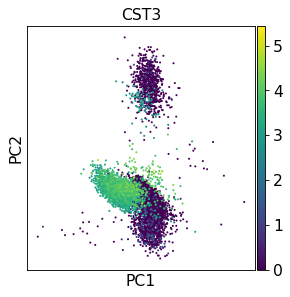

In [56]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='CST3')

Evaluate how many PCs is it worth using in the analysis:

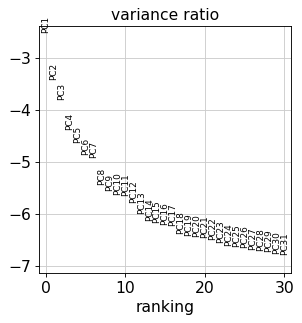

In [57]:
sc.pl.pca_variance_ratio(adata, log=True)

Calculate neighborhood graph, do UMAP, and do clustering the same way we did before:

In [58]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
sc.tl.umap(adata)
sc.tl.leiden(adata)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)
running Leiden clustering
    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [59]:
sc.tl.leiden(adata,resolution = 0.8)

running Leiden clustering
    finished: found 16 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


Visualize the obtained clusters using UMAP representation:

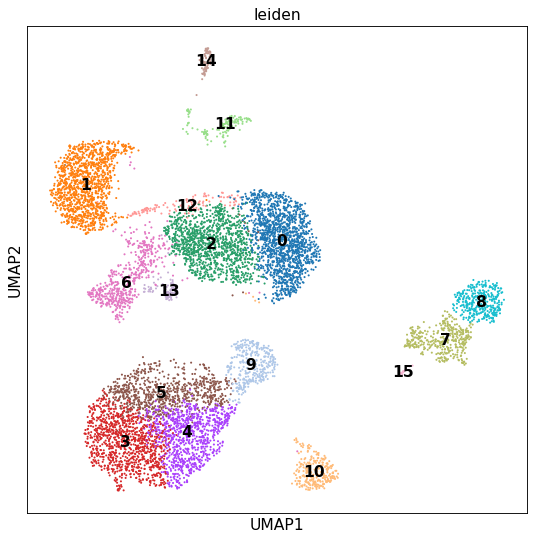

In [60]:
with mpl.rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(adata, color=['leiden'],legend_loc='on data')

If UMAP looks slightly less than perfect, we can use the following trick from the `scanpy` tutorial page:

In [61]:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


After this, take another look at the updated UMAP. Looks better!

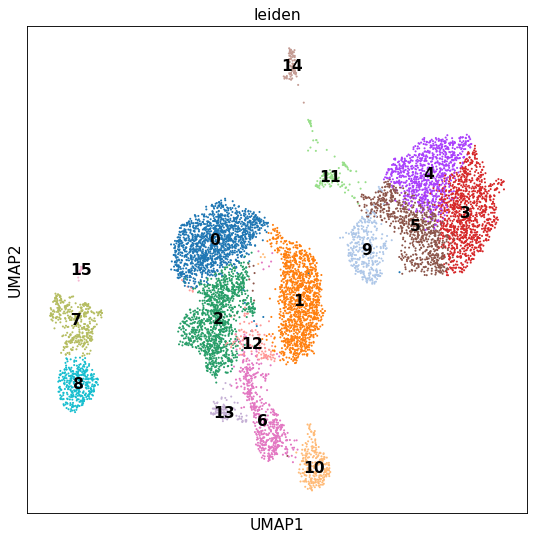

In [62]:
with mpl.rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(adata, color=['leiden'],legend_loc='on data')

Let's visualize more detailed markers of PBMC cell types:

| Marker | Cell type | 
| :-: | :-: |
| LYZ | monocytes |
| MS4A1 | B cells |
| CD8B | CD8 T cells |
| CCR7 | CD4 naive T cells |
| IL32 | CD4 memory T cells |
| NKG7 | natural killer cells |
| LILRA4 | plasmacytoid dendritic cells |
| FCER1A | myeloid dendritic cells |
| PPBP | platelets |

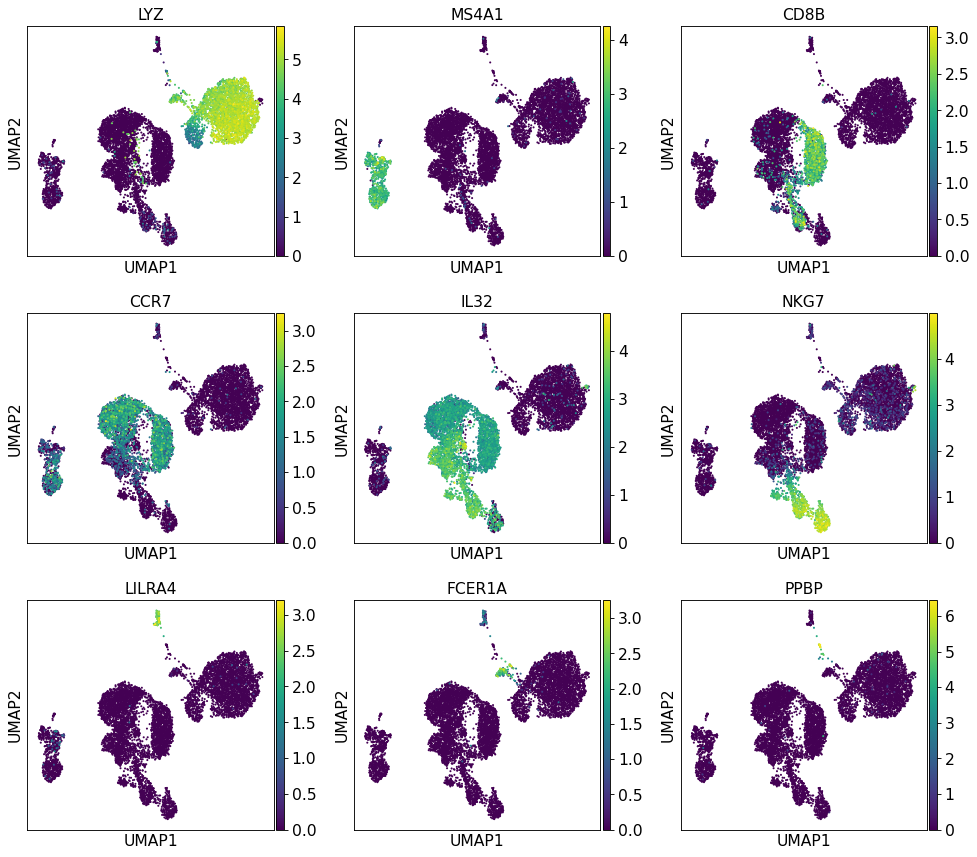

In [63]:
sc.pl.umap(adata, color=['LYZ','MS4A1','CD8B','CCR7','IL32','NKG7','LILRA4','FCER1A','PPBP'], ncols = 3)

Cluster 10 is clearly heterogeneous and consists of both platelets (with markers such as PPBP) and myeloid cells, most probably mDCs (LYZ, FCER1A). We need to adjust clustering resolution in such way that we would have these subpopulations split. 

Let's first try changing the resolution of Leiden clustering, saving new clusters as separate columns in `adata` column metadata (obs).

In [64]:
sc.tl.leiden(adata, resolution = 1.2, key_added = "leiden_1.2")
sc.tl.leiden(adata, resolution = 1.5, key_added = "leiden_1.5")
sc.tl.leiden(adata, resolution = 2.0, key_added = "leiden_2.0")

running Leiden clustering
    finished: found 18 clusters and added
    'leiden_1.2', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 22 clusters and added
    'leiden_1.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 28 clusters and added
    'leiden_2.0', the cluster labels (adata.obs, categorical) (0:00:00)


Let's visualize clusters with labels on clusters for clarity. It appears that we get too many cluster before we're able to split the original cluster (10) into sub-populations.

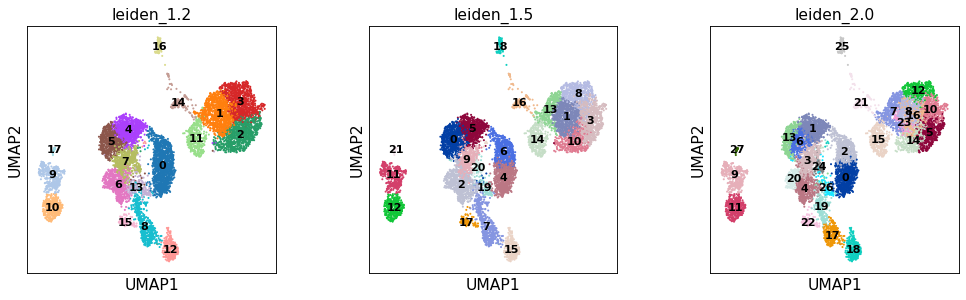

In [65]:
sc.pl.umap(adata, color=['leiden_1.2', 'leiden_1.5', 'leiden_2.0'], legend_loc='on data', wspace = 0.25, legend_fontsize=10)

Let's try some other approaches. For example, we can try k-means clustering with 15, 20, or 25 expected clusters. 

... storing 'kmeans15' as categorical
... storing 'kmeans20' as categorical
... storing 'kmeans25' as categorical


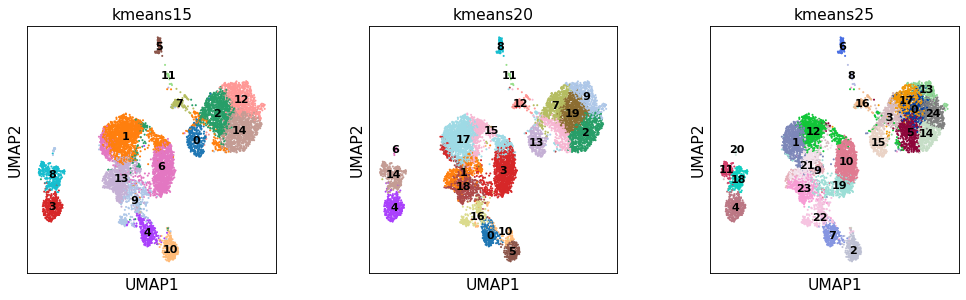

In [66]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
X_pca = adata.obsm['X_pca'] 

kmeans = KMeans(n_clusters=15, random_state=0).fit(X_pca) 
adata.obs['kmeans15'] = kmeans.labels_.astype(str)
kmeans = KMeans(n_clusters=20, random_state=0).fit(X_pca) 
adata.obs['kmeans20'] = kmeans.labels_.astype(str)
kmeans = KMeans(n_clusters=25, random_state=0).fit(X_pca) 
adata.obs['kmeans25'] = kmeans.labels_.astype(str)

sc.pl.umap(adata, color=['kmeans15', 'kmeans20', 'kmeans25'], legend_loc='on data', wspace = 0.25, legend_fontsize=10)

We can also try hierarchical clustering using Euclidean distance as a metric, and Ward's linkage method. 

... storing 'hclust15' as categorical
... storing 'hclust20' as categorical
... storing 'hclust25' as categorical


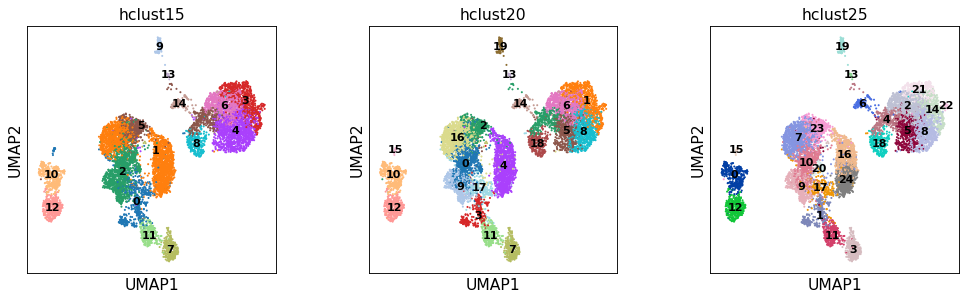

In [67]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=15, affinity='euclidean', linkage='ward')
adata.obs['hclust15'] = cluster.fit_predict(X_pca).astype(str)

cluster = AgglomerativeClustering(n_clusters=20, affinity='euclidean', linkage='ward')
adata.obs['hclust20'] = cluster.fit_predict(X_pca).astype(str)

cluster = AgglomerativeClustering(n_clusters=25, affinity='euclidean', linkage='ward')
adata.obs['hclust25'] = cluster.fit_predict(X_pca).astype(str)

sc.pl.umap(adata, color=['hclust15', 'hclust20', 'hclust25'], legend_loc='on data', wspace = 0.25, legend_fontsize=10)

In general, k-means and hierarchical clusters seem to poorly represent the communities, easily shifting from under- to over-clustering. At the same time, one of the clusters from our initial Leiden clustering is always split into platelet/DC sub-populations. This indirectly confirms our previous conclusions. Thus, let's manually split this cluster using well-known markers of platelets.

In [68]:
adata.obs['leiden'].value_counts()

0     1438
1     1221
2     1155
3     1033
4      900
5      754
6      529
7      379
8      358
9      327
10     267
11     134
12     120
13     105
14      87
15      17
Name: leiden, dtype: int64

One of the clusters is clearly divided into two by the following markers (PPBP is a marker of platelets, and FCER1A is a marker of myeloid DCs)

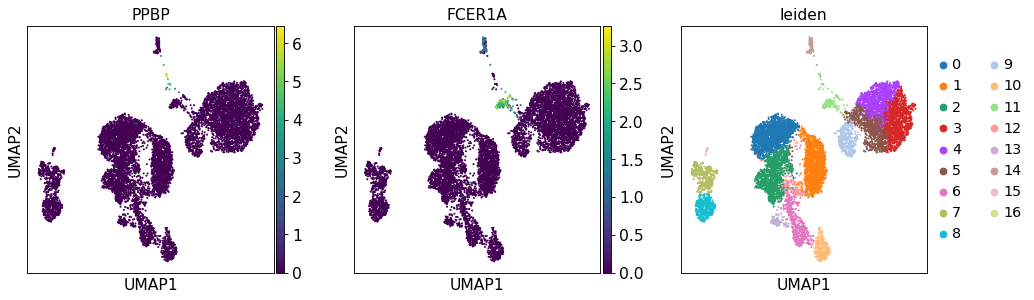

In [79]:
sc.pl.umap(adata, color=['PPBP','FCER1A','leiden'])

Let's find which cells of cluster 10 are platelets. The following expression shows a useful way to slice `scanpy` object on multiple gene expression values. The resulting subset should contain 25 cells.

In [80]:
platelets = adata[(adata[:,'GP1BB'].X > 1) & (adata[:,'PPBP'].X > 1) & (adata[:,'PF4'].X > 1), :]
platelets

View of AnnData object with n_obs × n_vars = 31 × 2005
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'Doublet_score', 'Is_doublet', 'QC', 'leiden', 'S_score', 'G2M_score', 'phase', 'leiden_1.2', 'leiden_1.5', 'leiden_2.0', 'kmeans15', 'kmeans20', 'kmeans25', 'hclust15', 'hclust20', 'hclust25'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'rb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'paga', 'leiden_sizes', 'leiden_1.2_colors', 'leiden_1.5_colors', 'leiden_2.0_colors', 'kmeans15_colors', 'kmeans20_colors', 'kmeans25_colors', 'hclust15_colors', 'hclust20_colors', 'hclust25_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

We can get the indexes of putative platelets from cluster 10 as follows:

In [82]:
platelets.obs_names

Index(['AACAGGGAGTACAGCG-1', 'ACCTACCCACATACTG-1', 'ACTGTCCTCGCAGTGC-1',
       'AGCCAATTCCGGGACT-1', 'AGGATCTTCACATACG-1', 'AGTCATGCATTGCCGG-1',
       'ATACTTCAGCAGTAAT-1', 'CACACAATCTCTCAAT-1', 'CACGAATAGGGCATGT-1',
       'CACGTGGGTATAATGG-1', 'CAGATTGGTCAGATTC-1', 'CATCAAGTCGTTCATT-1',
       'CATCCCAGTAAGTCAA-1', 'CATGCGGAGTCCGCCA-1', 'CCGGACATCAATCCAG-1',
       'CCGTGAGTCTGCGATA-1', 'CGGACACAGTGGTGAC-1', 'GACTCTCCATTAGGAA-1',
       'GATCCCTAGCGGTAGT-1', 'GTCACGGGTCGAATTC-1', 'GTCAGCGTCGCTACAA-1',
       'GTGAGTTCAATTCTCT-1', 'GTTACGAGTTCAGTAC-1', 'GTTAGTGTCCCATTTA-1',
       'TACGTCCTCTGGGCGT-1', 'TAGATCGTCCGCATAA-1', 'TCCGATCGTACTCGAT-1',
       'TCGAACAAGCTGCCAC-1', 'TCTGTCGGTCTGGTTA-1', 'TGTAAGCAGAAACTCA-1',
       'TTGTGTTTCCCGTGTT-1'],
      dtype='object')

The following commands allow us to add another category to the 'leiden' column of the metadata, and set the selected cells to belong to the new cluster:

In [83]:
adata.obs['leiden'] = adata.obs['leiden'].cat.add_categories('16')
adata.obs.loc[lambda df: df.index.isin(platelets.obs.index),'leiden'] = '16'

Finally, let's make sure the clustering looks right: 

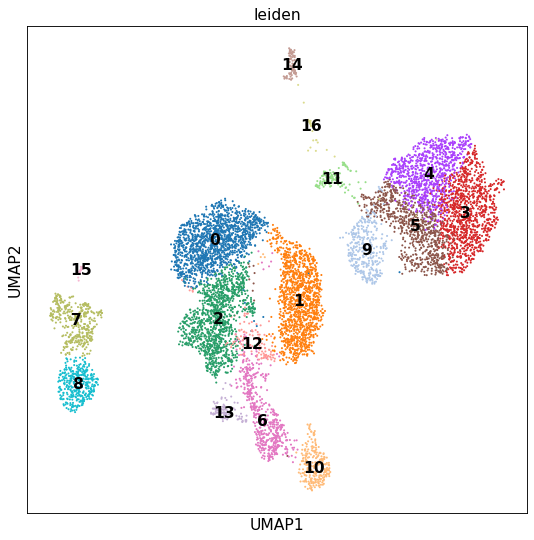

In [84]:
with mpl.rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(adata, color=['leiden'],legend_loc='on data')

### PART 4. Differential expression and marker selection.

After we have fixed the clusters, let's make gene markers using Wilcoxon test. Score plotting for each cluster allows to estimate the relative "goodness" of a marker in a quick fashion.

In [85]:
adata

AnnData object with n_obs × n_vars = 8824 × 2005
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'Doublet_score', 'Is_doublet', 'QC', 'leiden', 'S_score', 'G2M_score', 'phase', 'leiden_1.2', 'leiden_1.5', 'leiden_2.0', 'kmeans15', 'kmeans20', 'kmeans25', 'hclust15', 'hclust20', 'hclust25'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'rb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'paga', 'leiden_sizes', 'leiden_1.2_colors', 'leiden_1.5_colors', 'leiden_2.0_colors', 'kmeans15_colors', 'kmeans20_colors', 'kmeans25_colors', 'hclust15_colors', 'hclust20_colors', 'hclust25_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:14)


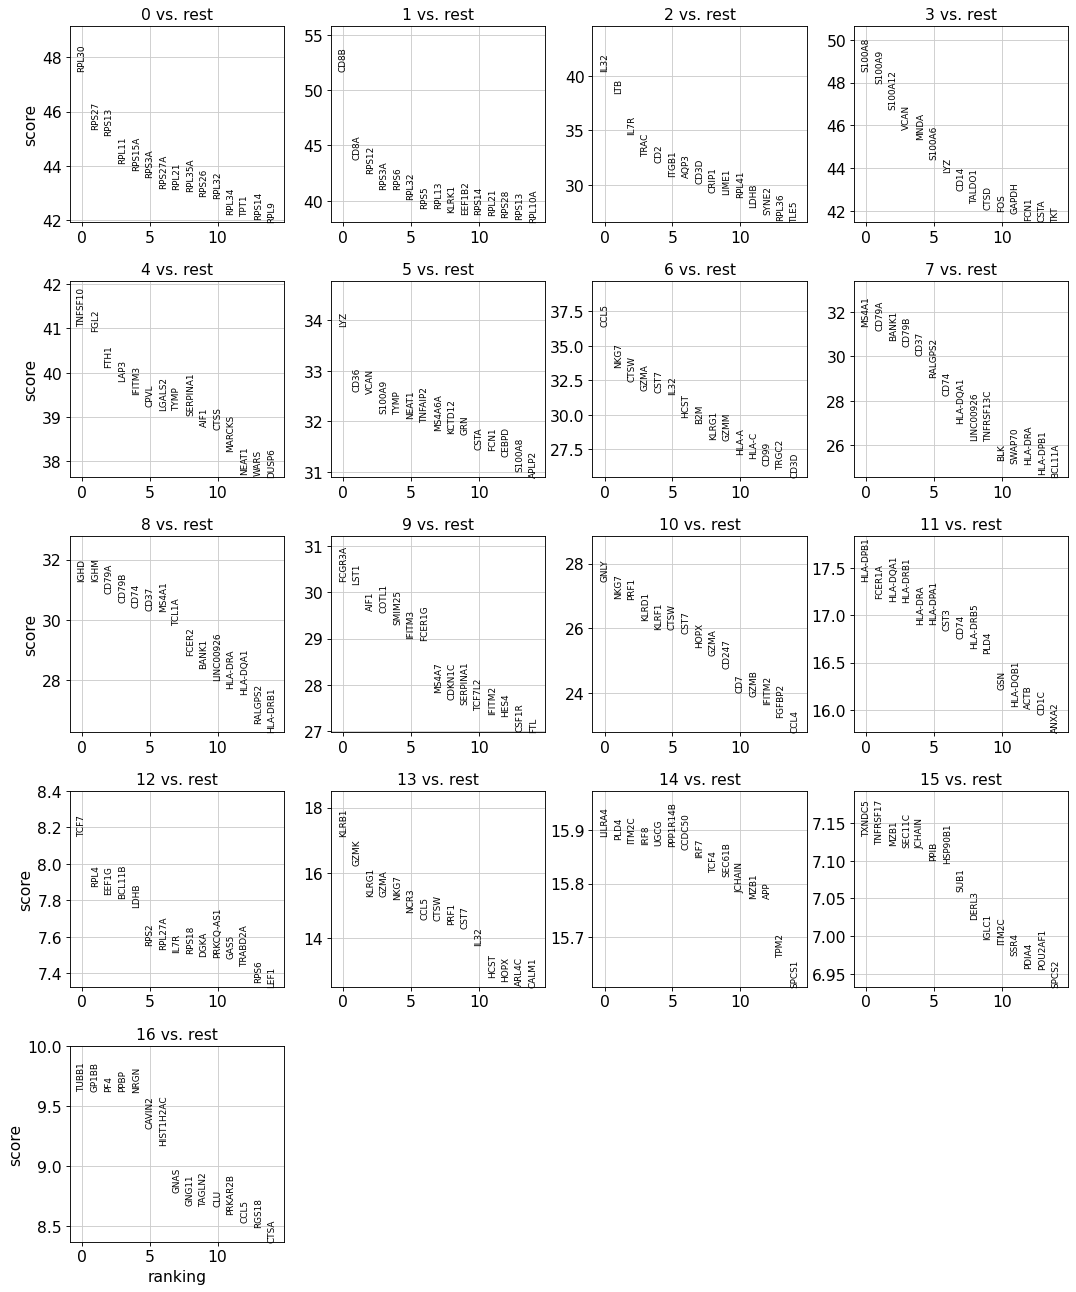

In [86]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=15, sharey=False)

While some clusters have uninformative markers (e.g. cluster 0 mostly shows ribosomal proteins), most others identify what seems to be legitimate subpopulations of lymphocytes. Let's define a set of markers that are known from the literature or have been identified in our marker selection process:

In [87]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1', 'IGLC1','IL32',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP','LILRA4']

Let's take a closer look at top 5 ranked markers for each cluster: 

In [88]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

0      1     2        3        4       5     6      7      8       9  \
0   RPL30   CD8B  IL32   S100A8  TNFSF10     LYZ  CCL5  MS4A1   IGHD  FCGR3A   
1   RPS27   CD8A   LTB   S100A9     FGL2    CD36  NKG7  CD79A   IGHM    LST1   
2   RPS13  RPS12  IL7R  S100A12     FTH1    VCAN  CTSW  BANK1  CD79A    AIF1   
3   RPL11  RPS3A  TRAC     VCAN     LAP3  S100A9  GZMA  CD79B  CD79B   COTL1   
4  RPS15A   RPS6   CD2     MNDA   IFITM3    TYMP  CST7   CD37   CD74  SMIM25   

      10        11      12     13      14        15     16  
0   GNLY  HLA-DPB1    TCF7  KLRB1  LILRA4    TXNDC5  TUBB1  
1   NKG7    FCER1A    RPL4   GZMK    PLD4  TNFRSF17  GP1BB  
2   PRF1  HLA-DQA1   EEF1G  KLRG1   ITM2C      MZB1    PF4  
3  KLRD1  HLA-DRB1  BCL11B   GZMA    IRF8    SEC11C   PPBP  
4  KLRF1   HLA-DRA    LDHB   NKG7    UGCG    JCHAIN   NRGN

Seaborn (split violin) plots of gene expression in a given cluster vs the rest of cells can help easily identify more robust cluster markers. In the example below, ribosomal genes should not be used as markers, while CD8A and CD8B represent *bona fide* markers of CD8 T cells.

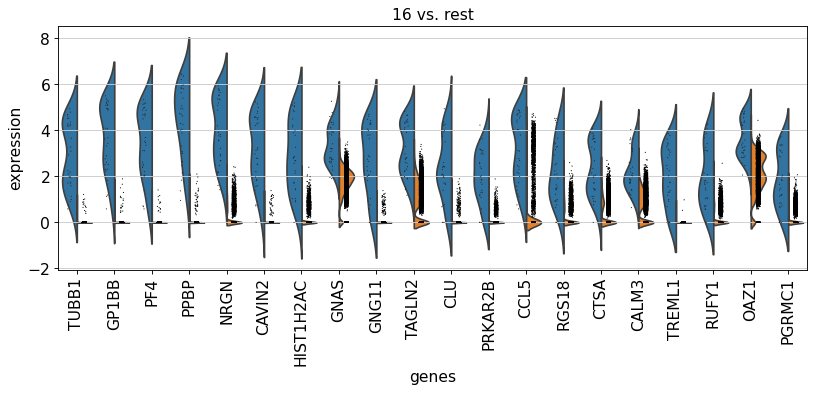

In [89]:
with mpl.rc_context({'figure.figsize': (12, 4)}):
    sc.pl.rank_genes_groups_violin(adata, groups='16', n_genes=20)

Simple violin plots grouped by cluster also offer a good visualisation:

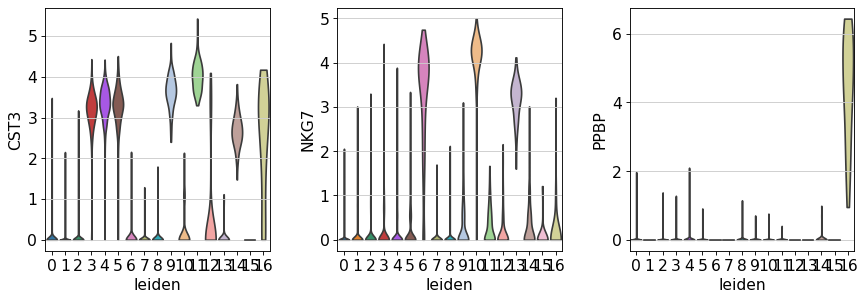

In [90]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden', stripplot = False )

Dotplot can generate a bird's eye view of expression of all selected marker genes in all clusters.

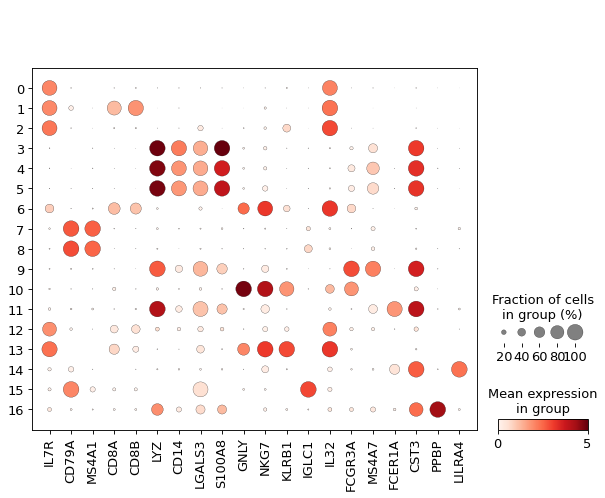

In [91]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden')

Yet another option is given by stacked violin plot.

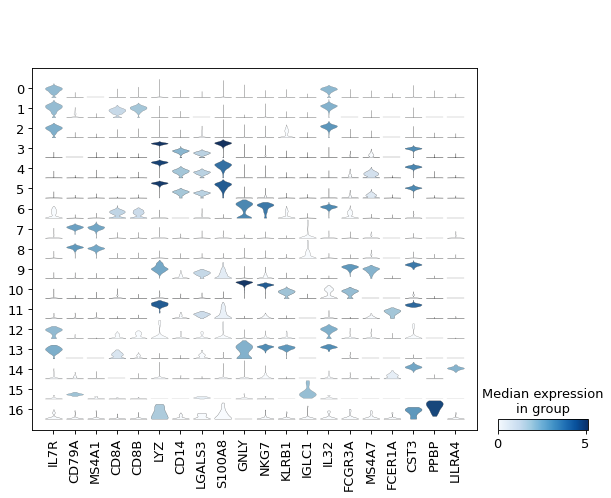

In [92]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90)

### PART 5. Cell ontology-based automatic cell type prediction with `CellO`

The following analysis is based on [this tutorial](https://github.com/deweylab/CellO/blob/master/tutorial/cello_tutorial.ipynb) provided for `CellO` package. The package is actively developed and is very useful for broad cell type annotation, as well as for annotation of cell types defined by [Cell Ontology](https://www.ebi.ac.uk/ols/ontologies/cl). To install `CellO`, we can run the following commands:

In [93]:
! sudo apt-get -y install libgraphviz-dev
! sudo apt-get -y install graphviz
! pip install --no-input -U cello-classify --no-cache

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libcdt5 libcgraph6 libgts-0.7-5 libgts-bin libgvc6 libgvc6-plugins-gtk
  libgvpr2 liblab-gamut1 libpathplan4 libxdot4
The following NEW packages will be installed:
  libcdt5 libcgraph6 libgraphviz-dev libgts-0.7-5 libgts-bin libgvc6
  libgvc6-plugins-gtk libgvpr2 liblab-gamut1 libpathplan4 libxdot4
0 upgraded, 11 newly installed, 0 to remove and 6 not upgraded.
Need to get 1,357 kB of archives.
After this operation, 6,400 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 libcdt5 amd64 2.42.2-3build2 [18.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libcgraph6 amd64 2.42.2-3build2 [41.3 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 libgts-0.7-5 amd64 0.7.6+darcs121130-4 [150 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal/universe amd64 libpathplan4

  Created wheel for quadprog: filename=quadprog-0.1.10-cp38-cp38-linux_x86_64.whl size=473848 sha256=39bd78d3042c3ae05752835fed52bd8b6c61605b2f285410b0cfd7a7e95b10ae
  Stored in directory: /tmp/pip-ephem-wheel-cache-grm91jzx/wheels/1a/73/9e/643ca13f12dc01433ccd2e40c4167b8b0fdf69b53038ae80d0
  Created wheel for pygraphviz: filename=pygraphviz-1.7-cp38-cp38-linux_x86_64.whl size=230529 sha256=88545541dc6d734ee0e5632813b7dbd8ab267b65a7f447cc0d539d50a24f9671
  Stored in directory: /tmp/pip-ephem-wheel-cache-grm91jzx/wheels/77/c6/8b/566e1c26d0f9d41093e28d8e1768f1412d54846e3296114feb
Successfully built quadprog pygraphviz


After this (we assume we already imported `pandas`, `numpy`, `scanpy`, and `AnnData` - see above), we run

In [94]:
import os
import cello

First of all, let's "recall" the raw data to adata again; we'll need the lists of retained cells and genes for the downstream analysis, but we'll do the normalization and variable gene selection from the scratch. 

In [95]:
adata = adata.raw.to_adata()
adata

AnnData object with n_obs × n_vars = 8824 × 22010
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'Doublet_score', 'Is_doublet', 'QC', 'leiden', 'S_score', 'G2M_score', 'phase', 'leiden_1.2', 'leiden_1.5', 'leiden_2.0', 'kmeans15', 'kmeans20', 'kmeans25', 'hclust15', 'hclust20', 'hclust25'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'rb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'paga', 'leiden_sizes', 'leiden_1.2_colors', 'leiden_1.5_colors', 'leiden_2.0_colors', 'kmeans15_colors', 'kmeans20_colors', 'kmeans25_colors', 'hclust15_colors', 'hclust20_colors', 'hclust25_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'

In [96]:
new_adata = sc.read_10x_mtx('../data/soupX_pbmc10k_filt', cache = True)
new_adata

... reading from cache file cache/..-data-soupX_pbmc10k_filt-matrix.h5ad


AnnData object with n_obs × n_vars = 10194 × 36601
    var: 'gene_ids', 'feature_types'

In [97]:
new_adata = new_adata[adata.obs_names,adata.var_names]
new_adata

View of AnnData object with n_obs × n_vars = 8824 × 22010
    var: 'gene_ids', 'feature_types'

Let's normalize the data and find the highly variable genes - note the unusually high number of HVGs (10k). This follows the suggestion in the `CellO` tutorial:

In [98]:
sc.pp.normalize_total(new_adata, target_sum=1e6)
sc.pp.log1p(new_adata)
sc.pp.highly_variable_genes(new_adata, n_top_genes=10000)
new_adata

/opt/conda/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 8824 × 22010
    var: 'gene_ids', 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

Now let's cluster the data. Over-clustering is recommended here, for the reasons that would become clear below:

In [99]:
sc.pp.pca(new_adata, n_comps=50, use_highly_variable=True)
sc.pp.neighbors(new_adata, n_neighbors=15)
sc.tl.leiden(new_adata, resolution=2.0)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:01:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Leiden clustering
    finished: found 26 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


Currently, `CellO` only supports dense matrix format, so we need to do the transformation below. Note that it needs to be done after all `Scanpy` operations.

In [100]:
new_adata.X = new_adata.X.todense()

Finally, let's set the `CellO` resource directory to the dir where this notebook is located. NOTE: You will need at least 5 Gb of free disk space for the following code to work. 

In [101]:
cello_resource_loc = os.getcwd()

Following this, we can train the model using `CellO` using the following command. This runs for about an hour, and will make a file called `10k_pbmc.model.dill`.

```
model_prefix = "10k_pbmc"

cello.scanpy_cello(
    new_adata, clust_key='leiden', rsrc_loc=cello_resource_loc, 
    out_prefix=model_prefix, log_dir=os.getcwd()
)
```

Instead, we will download a pre-made model to save time: 

In [102]:
! wget https://www.dropbox.com/s/x8n6jxa9ygw3s1w/10k_pbmc.model.dill

--2021-11-19 20:10:55--  https://www.dropbox.com/s/x8n6jxa9ygw3s1w/10k_pbmc.model.dill
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6020:18::a27d:4012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/x8n6jxa9ygw3s1w/10k_pbmc.model.dill [following]
--2021-11-19 20:10:55--  https://www.dropbox.com/s/raw/x8n6jxa9ygw3s1w/10k_pbmc.model.dill
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5253187eac9ade511b213500c4.dl.dropboxusercontent.com/cd/0/inline/BaTYnz0epf0zvlUjvirJQ91TUFQKN7QJ9pJIm2aSbdCGhthK5UwRjpP_oPqghFvPfdM5LjuugI-sZNZpIG-ZrHDkwlEE2GDMYwPLXoZRQlSaaUl25e5BTrKEb9XEhKC-k8558MIEh6fH3qbBB4KDoz5y/file# [following]
--2021-11-19 20:10:56--  https://uc5253187eac9ade511b213500c4.dl.dropboxusercontent.com/cd/0/inline/BaTYnz0epf0zvlUjvirJQ91TUFQKN7QJ9pJIm2aSbdCGhthK5UwRjpP_oPqghFvPfd

Following this, we can run the cell type annotation command with a pre-made model: 

In [103]:
model_prefix = "10k_pbmc"

cello.scanpy_cello(
    new_adata, 
    clust_key='leiden',
    rsrc_loc=cello_resource_loc,  
    model_file=f'{model_prefix}.model.dill'
)

Loading model from 10k_pbmc.model.dill...


/opt/conda/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator PCA from version 1.0.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.0.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(



        Could not find the CellO resources directory called
        'resources' in '/home/jovyan/notebooks/notebooks'. Will download resources to current 
        directory.
        
Running command: curl http://deweylab.biostat.wisc.edu/cell_type_classification/resources_v2.0.0.tar.gz > /home/jovyan/notebooks/notebooks/resources_v2.0.0.tar.gz
Running command: tar -C /home/jovyan/notebooks/notebooks -zxf resources_v2.0.0.tar.gz
Running command: rm /home/jovyan/notebooks/notebooks/resources_v2.0.0.tar.gz


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Transforming with PCA...
done.
Making predictions for each classifier...
Running solver on item 1/26...
Running solver on item 2/26...
Running solver on item 3/26...
Running solver on item 4/26...
Running solver on item 5/26...
Running solver on item 6/26...
Running solver on item 7/26...
Running solver on item 8/26...
Running solver on item 9/26...
Running solver on item 10/26...
Running solver on item 11/26...
Running solver on item 12/26...
Running solver on item 13/26...
Running solver on item 14/26...
Running solver on item 15/26...
Running solver on item 16/26...
Running solver on item 17/26...
Running solver on item 18/26...
Running solver on item 19/26...
Running solver on item 20/26...
Running solver on item 21/26...
Running solver on item 22/26...
Running solver on item 23/26...
Running solver on item 24/26...
Running solver on item 25/26...
Running solver on item 26/26...
Checking if any pre-trained model is compatible with this input dataset...


/opt/conda/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator PCA from version 0.22.2.post1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.22.2.post1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


Of 22010 genes in the input file, 16803 were found in the training set of 58243 genes.
Of 22010 genes in the input file, 16115 were found in the training set of 31283 genes.
Using thresholds stored in /home/jovyan/notebooks/notebooks/resources/trained_models/ir.10x_genes_thresholds.tsv
Binarizing classifications...
Mapping each sample to its predicted labels...
Computing the most-specific predicted labels...
Loading ontology...
Item 0 predicted to be "naive thymus-derived CD4-positive, alpha-beta T cell (CL:0000895)"
Item 1 predicted to be "central memory CD4-positive, alpha-beta T cell (CL:0000904)"
Item 10 predicted to be "naive B cell (CL:0000788)"
Item 11 predicted to be "naive thymus-derived CD4-positive, alpha-beta T cell (CL:0000895)"
Item 12 predicted to be "naive thymus-derived CD4-positive, alpha-beta T cell (CL:0000895)"
Item 13 predicted to be "CD14-positive, CD16-negative classical monocyte (CL:0002057)"
Item 14 predicted to be "naive thymus-derived CD4-positive, alpha-bet

Let's run UMAP and visualized the obtained clusters. Quite clearly this is too many, but it's OK: 

In [104]:
sc.tl.umap(new_adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


... storing 'Most specific cell type' as categorical
... storing 'feature_types' as categorical


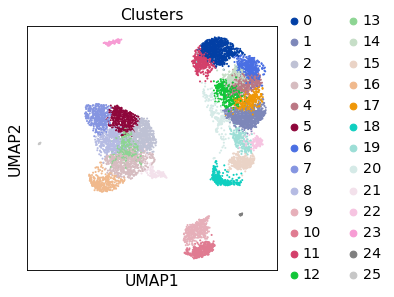

In [105]:
fig = sc.pl.umap(new_adata, color='leiden', title='Clusters', return_fig=True)

The following example can be useful to save the plots in the pdf format: 

In [106]:
out_file = '10k_pbmc_clusters_res2.0.pdf' # <-- Name of the output file

fig.savefig(out_file, bbox_inches='tight', format='pdf')

Let's visualize a most specific cell type for each cluster: 

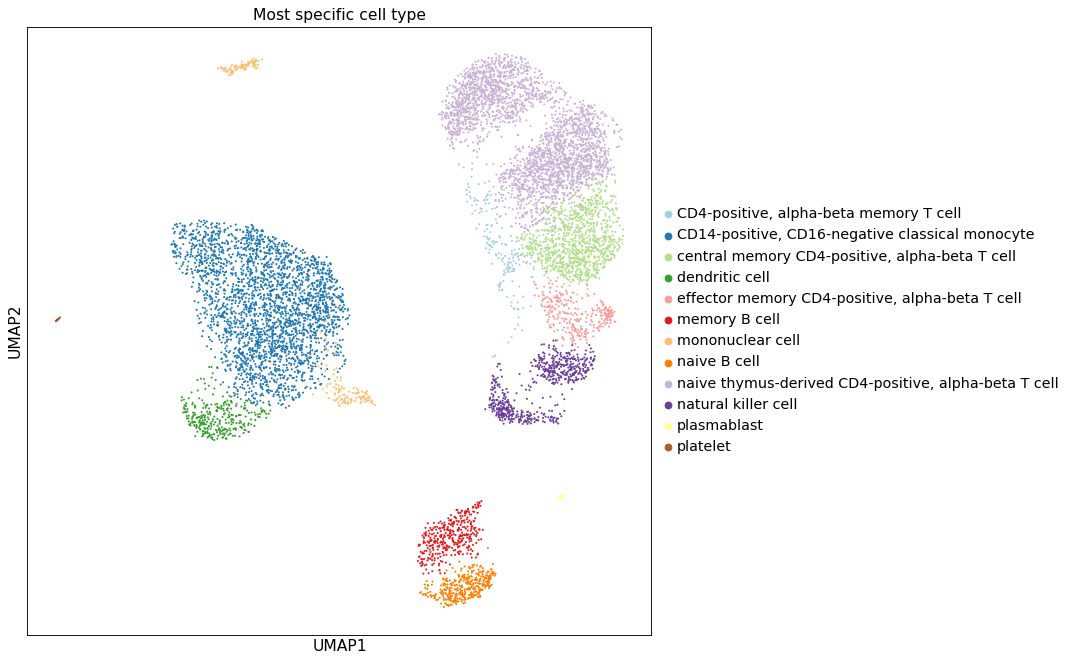

In [107]:
import matplotlib as mpl

with mpl.rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(new_adata, color='Most specific cell type',palette="Paired")

We can see that some of these assignments are wrong; for example, what's marked as "dendiritic cell" in the plot above is actually a population of non-classical monocytes (as shown by expression of FCGR3A). At the same time, what's labelled as "mononuclear cell" is in fact two populations of dendritic cells - myeloid DCs (expressing FCER1A) and plasmacytoid DCs (expressing LILRA4):

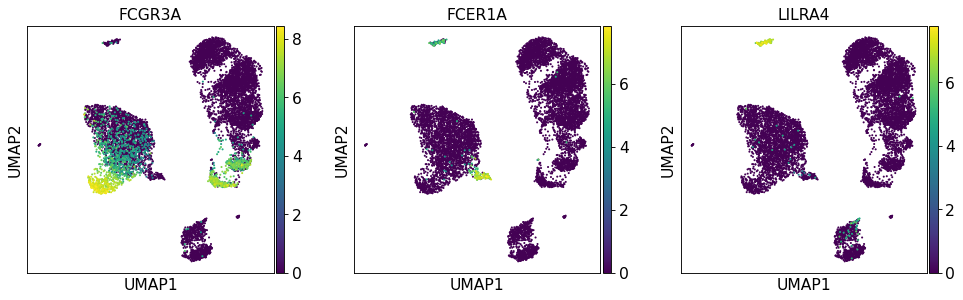

In [108]:
sc.pl.umap(new_adata, color=["FCGR3A","FCER1A","LILRA4"])

Assigned probability can be used to visualize the probability of cell being a certain cell type:  

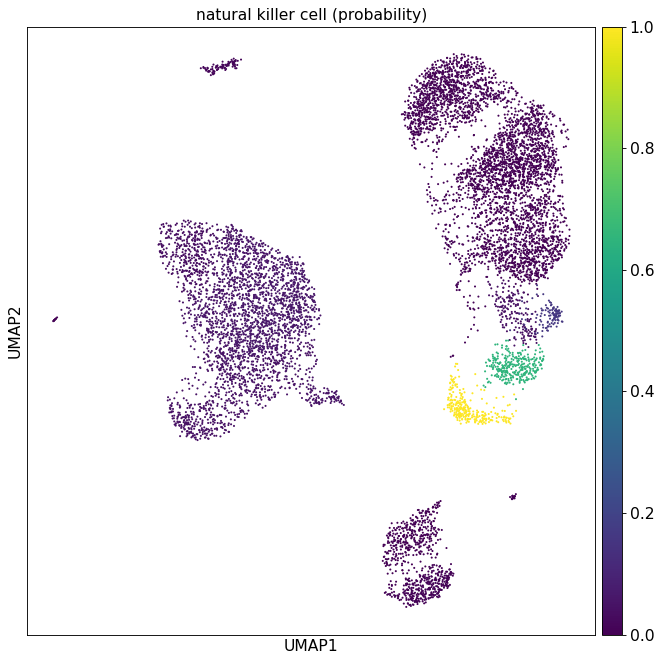

In [109]:
with mpl.rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(new_adata, color='natural killer cell (probability)', vmin=0.0, vmax=1.0, return_fig=True)

We can also use more abstract ontologies, e.g. to identify nucleate cells (platelets don't have nuclei!):

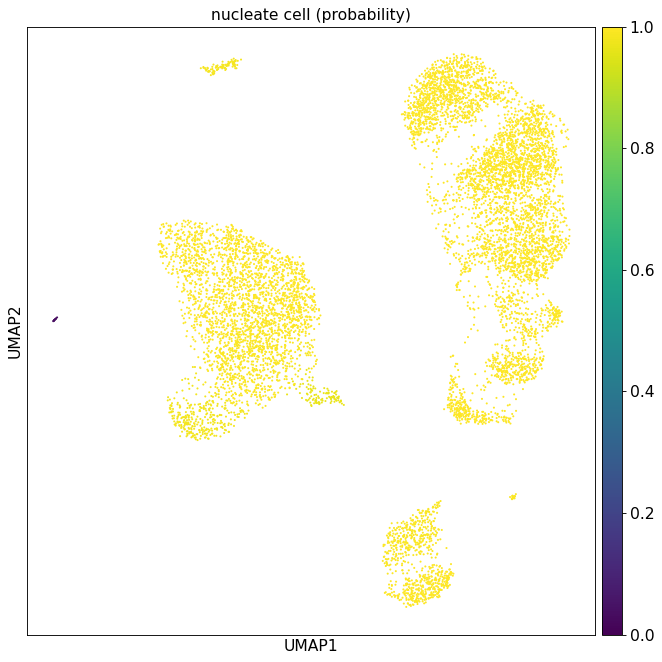

In [110]:
with mpl.rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(new_adata, color='nucleate cell (probability)', vmin=0.0, vmax=1.0, return_fig=True)

Finally, we can use the result of binary classification:

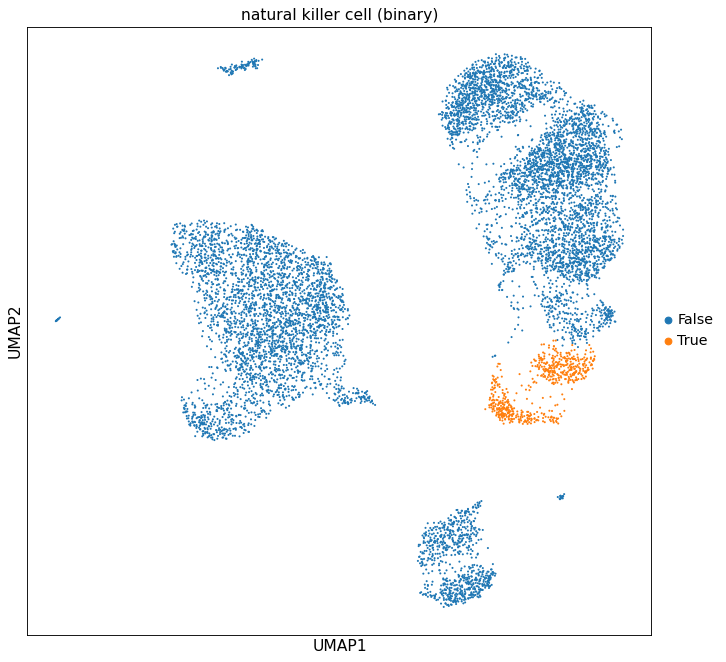

In [111]:
with mpl.rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(new_adata, color='natural killer cell (binary)', vmin=0.0, vmax=1.0, return_fig=True)

Additionally, we can visualize cell type probabilities assigned to a specific cluster overlaid on the Cell Ontology graph:

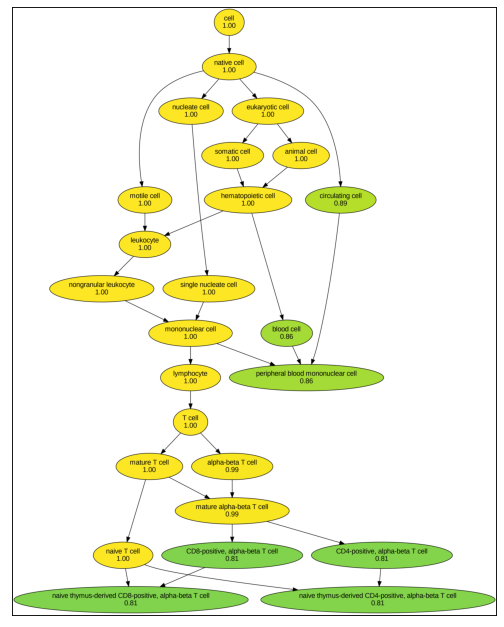

In [112]:
fig, ax = cello.cello_probs(new_adata, '11', cello_resource_loc, 0.5, clust_key='leiden');